# Harvest Wisely

This notebook outlines the general workflow for the data within the [Harvest Wisely](https://oceancentral.org/track/harvest-wisely) page of the Ocean Central website.

# Fish and Seafood

## Figure 1

This is a raw passthrough of data from RAM Legacy Database, which can be downloaded from [here](https://ourworldindata.org/grapher/biomass-fish-stocks-taxa?tab=table&country=Tuna~Mackerels~Shrimps~Sharks+and+rays~Cod+and+haddock~Perch+and+rockfish).


Data source: RAM Legacy Database; Hilborn,et al. (2020). Effective fisheries management instrumental in improving fish stock status.    

<p align="center">
  <img src="Figs/harvest_fish_1.png" style="width:50%;">
</p>

## Figure 2

This is a raw passthrough of data from FAO. 2024. The State of World Fisheries and Aquaculture 2024 – Blue Transformation in action. Rome.

<p align="center">
  <img src="Figs/harvest_fish_2.png" style="width:50%;">
</p>

## Figure 3

This figure loads in the RAM Legacy Database and maps each stock's most recent measurement of Maximum Sustainable Yield (MSY) to the FAO-defined fishing zones. It then classifies each stock as "surplus", "overfished", or "sustainable" based on its MSY value.

<p align="center">
  <img src="Figs/harvest_fish_3.png" style="width:50%;">
</p>

In [ ]:
import pandas as pd
import numpy as np

# Load the RAM Legacy Database timeseries data
df = pd.read_excel("../Data/RAMLDB v4.66 (assessment data only).xlsx", sheet_name="timeseries.1")

# Load the RAM Legacy Database stock data
region_df = pd.read_excel("../Data/RAMLDB v4.66 (assessment data only).xlsx", sheet_name="stock")

# Join the two pandas dataframes together
df = df.merge(region_df[['stockid','region']],on='stockid')

# Filter the data based on the 'tsid' to the Maximum Sustainable Yield variable and non-null 'tsvalue'
df = df.query("tsid == 'BdivBmsypref-dimensionless' & ~tsvalue.isna()")

# Get the newest value of 'tsvalue' for each 'stockid' based on the 'year'
latest_values = df.loc[df.groupby('stockid')['tsyear'].idxmax()]

# Display the result
latest_values

In [ ]:
# Define classification function for surplus, sustainable, and overfished 
def classify_msy(value):
    if value > 0.8:
        return "not_overfished"
    else:
        return "overfished"

# Define the mapping from regions to FAO zone numbers
region_to_fao_zone = {
    'US East Coast': '21',
    'South America': '41, 87',
    'Indian Ocean': '51, 57',
    'Mediterranean-Black Sea': '37',
    'Atlantic Ocean': '21, 27, 31, 34, 41, 47',
    'Pacific Ocean': '67, 71, 77, 81, 87',
    'US Alaska': '67',
    'European Union': '27, 37',
    'Japan': '61',
    'US West Coast': '67, 77',
    'Canada East Coast': '21',
    'Other': np.nan,
    'New Zealand': '81',
    'Australia': '57, 71, 81',
    'US Southeast and Gulf': '31',
    'Canada West Coast': '67',
    'Europe non EU': '27',
    'Southern Africa': '47, 51',
    'US Hawaii': '77'
}

# Apply classification to 'tsvalue'
latest_values['classification'] = latest_values['tsvalue'].apply(classify_msy)

# Apply the mapping to create a new column in the DataFrame
latest_values['FAO_zone'] = latest_values['region'].map(region_to_fao_zone)
latest_values

# Split rows with multiple FAO zones into separate rows
data_expanded = latest_values.dropna(subset=['FAO_zone']).assign(
    FAO_zone=latest_values['FAO_zone'].str.split(', ')
).explode('FAO_zone')

# Convert FAO_zone to integers
data_expanded['FAO_zone'] = data_expanded['FAO_zone'].astype(int)

# Group by FAO zone and count the number of rows for each classification
grouped_data = data_expanded.groupby('FAO_zone')['classification'].value_counts().unstack(fill_value=0)

# Rename columns for clarity
grouped_data = grouped_data.rename(columns={
    'not_overfished': 'count_not_overfished',
    'overfished': 'count_overfished',
})

grouped_data = grouped_data.reset_index()

# Display the grouped data
grouped_data

import geopandas as gpd

# Read the FAO zones shapefile
zones_df = gpd.read_file("../Data/fao/World_Fao_Zones.shp")

# Merge the grouped data with the FAO zones GeoDataFrame
final_df = zones_df.merge(grouped_data, left_on='zone', right_on='FAO_zone')

# Ensure the final DataFrame is a GeoDataFrame
final_gdf = gpd.GeoDataFrame(final_df, geometry='geometry')

# FAO_zone to Fishing Zone mapping from your second image
fishing_zone_mapping = {
    18: "Arctic Sea",
    21: "Atlantic, Northwest",
    27: "Atlantic, Northeast",
    31: "Atlantic, Western-central",
    34: "Atlantic, Eastern Central",
    37: "Mediterranean and Black Sea",
    41: "Atlantic, Southwest",
    47: "Atlantic, Southeast",
    48: "Atlantic, Antarctic",
    51: "Indian Ocean, Western",
    57: "Indian Ocean, Eastern",
    58: "Indian Ocean, Antarctic And Southern",
    61: "Pacific, Northwest",
    67: "Pacific, Northeast",
    71: "Pacific, Western Central",
    77: "Pacific, Eastern Central",
    81: "Pacific, Southwest",
    87: "Pacific, Southeast",
    88: "Pacific, Antarctic"
}

# Create a new column by mapping FAO_zone to Fishing Zone
final_gdf['Fishing_Zone'] = final_gdf['FAO_zone'].map(fishing_zone_mapping)

# Save the result as a GeoJSON file
final_gdf[['Fishing_Zone','count_not_overfished','count_overfished','geometry']].to_file("../Data/harvest_wisely_3.geojson", driver='GeoJSON')
final_gdf

## Figure 4

This figure contains data from Food and Agriculture Organization of the United Nations (2024) – processed by Our World in Data, which can be found [here](https://ourworldindata.org/grapher/fish-seafood-production).

<p align="center">
  <img src="Figs/harvest_fish_4.png" style="width:50%;">
</p>

## Figure 5

This figure contains data from Food and Agriculture Organization of the United Nations (2024) – processed by Our World in Data, which can be found [here](https://ourworldindata.org/grapher/fish-and-seafood-consumption-per-capita).

<p align="center">
  <img src="Figs/harvest_fish_5.png" style="width:50%;">
</p>

## Figure 6

This figure contains data from Food and Agriculture Organization of the United Nations – Global aquatic trade - By partner country, which can be found [here](https://www.fao.org/fishery/statistics-query/en/trade_partners).

<p align="center">
  <img src="Figs/harvest_fish_6.png" style="width:50%;">
</p>

## Figure 7

This figure contains data from Food and Agriculture Organization of the United Nations – Global aquatic trade - By partner country, which can be found [here](https://www.fao.org/fishery/statistics-query/en/trade_partners).

<p align="center">
  <img src="Figs/harvest_fish_7.png" style="width:50%;">
</p>

## Figure 8

**BLANK**

## Figure 9

This figure contains data from Food and Agriculture Organization of the United Nations (2024) – processed by Our World in Data, which can be found [here](https://ourworldindata.org/grapher/fish-seafood-production).

<p align="center">
  <img src="Figs/harvest_fish_9.png" style="width:50%;">
</p>

## Figure 10

This figure contains data from Food and Agriculture Organization of the United Nations (2024) – processed by Our World in Data, which can be found [here](https://ourworldindata.org/grapher/fish-and-seafood-consumption-per-capita).

<p align="center">
  <img src="Figs/harvest_fish_10.png" style="width:50%;">
</p>

## Figure 11

This figure contains data from Food and Agriculture Organization of the United Nations – Global aquatic trade - By partner country, which can be found [here](https://www.fao.org/fishery/statistics-query/en/trade_partners).

<p align="center">
  <img src="Figs/harvest_fish_11.png" style="width:50%;">
</p>

## Figure 12

This figure contains data from Food and Agriculture Organization of the United Nations – Global aquatic trade - By partner country, which can be found [here](https://www.fao.org/fishery/statistics-query/en/trade_partners).

<p align="center">
  <img src="Figs/harvest_fish_12.png" style="width:50%;">
</p>

# Seaweed & Algae

## Figure 1 (key stats)

Data sourced from FAO FishSTAT via FishStatJ, available [here](https://www.fao.org/fishery/en/topic/166235/en)

Dataset: Global Production by production source 1950-2023 (Release date: March 2025)

In [ ]:
# Import production data
production = pd.read_csv("fao_plants_production.csv", encoding="latin-1")

# Drop all the status columns (columns named 'S' or 'S.1', 'S.2', etc.)
status_cols = [col for col in production.columns if col == 'S' or col.startswith('S.')]
production = production.drop(columns=status_cols)

# Clean up year column names - remove brackets
production.columns = [col.replace('[', '').replace(']', '') for col in production.columns]

production_without_totals = production[~production["Detailed production source (Name)"].isna()]

# Total production in most recent year
total_production = production_without_totals["2023"].sum()
print(f"{total_production/(1e6):.2f} total millions of tonnes produced")

# Percent produced by aquaculture
aquaculture_sources = ['Aquaculture production (freshwater)',
       'Aquaculture production (marine)',
       'Aquaculture production (brackishwater)']
aquaculture_prod = production_without_totals[production_without_totals['Detailed production source (Name)'].isin(aquaculture_sources)]
total_aquaculture_prod = aquaculture_prod["2023"].sum()
perc_aquaculture = np.round(total_aquaculture_prod/total_production*100,decimals=2)
print(f"{perc_aquaculture}% produced by aquaculture")

# Save
key_stats = {"Millions of Tons of Seaweed Produced Annually": total_production/(1e6),
 "Amount of Seaweed Produced by Aquaculture (%)": perc_aquaculture}

with open("fig_1_key_stats.json", "w") as f:
    json.dump(key_stats, f, indent=2)

## Figures 2 and 9

Data sourced from FAO FishSTAT via FishStatJ, available [here](https://www.fao.org/fishery/en/topic/166235/en)

Dataset: Global Production by production source 1950-2023 (Release date: March 2025)

<p align="center">
  <img src="Figs/harvest_seaweed_2.png" style="width:50%;">
</p>

In [ ]:
# Yearly time series, seaweed and algae production (in tonnes)
# Separated into aquaculture, wild, and total

# Get capture production
capture_source = 'Capture production'
capture_prod = production[production['Detailed production source (Name)'] == capture_source]

# Get only the year columns (numeric columns)
year_cols = [col for col in production.columns if col.isdigit()]

# Sum each year column to get total production per year
aquaculture_timeseries = aquaculture_prod[year_cols].sum()
capture_timeseries = capture_prod[year_cols].sum()

# Convert to DataFrame for easier plotting/analysis
aquaculture_timeseries = aquaculture_timeseries.reset_index()
aquaculture_timeseries.columns = ['Year', 'aquaculture_prod_tonnes']
aquaculture_timeseries['Year'] = aquaculture_timeseries['Year'].astype(int)

capture_timeseries = capture_timeseries.reset_index()
capture_timeseries.columns = ['Year', 'capture_prod_tonnes']
capture_timeseries['Year'] = capture_timeseries['Year'].astype(int)

# Get total
total_production_timeseries = production_without_totals[year_cols].sum()
total_production_timeseries = total_production_timeseries.reset_index()
total_production_timeseries.columns = ['Year', 'total_prod_tonnes']
total_production_timeseries['Year'] = total_production_timeseries['Year'].astype(int)

production_timeseries = pd.merge(aquaculture_timeseries, capture_timeseries, how="outer", on="Year")
production_timeseries = pd.merge(production_timeseries, total_production_timeseries, how="outer", on="Year")

# Save timeseries
production_timeseries.to_json("figure_2_9_producers.json", orient="records", indent=4)

# Check mins and maxes
print(production_timeseries["total_prod_tonnes"].min())
print(production_timeseries["total_prod_tonnes"].max())

## Figure 3

From FAO FishSTAT, available [here](https://www.fao.org/fishery/en/topic/166235/en)

Dataset: Global Production by production source 1950-2023 (Release date: March 2025)

Country names from FAO Names of Countries and Territories Dataset, available [here](https://www.fao.org/nocs/en)

<p align="center">
  <img src="Figs/harvest_seaweed_3.png" style="width:50%;">
</p>

In [ ]:
# Production by country with ISO code for geo mapping (in tonnes)

# Check countries before merging
prod_2023 = production_without_totals[["Country (Name)","2023"]]

# Drop former countries
prod_2023 = prod_2023[~prod_2023["Country (Name)"].isin(["Union of Soviet Socialist Republics [former]", "Sudan [former]"])]
prod_2023_by_country = prod_2023.groupby(by="Country (Name)", as_index=False).agg({"2023":"sum"})

country_codes = pd.read_excel("FAO_country_names.xlsx")[["ISO3", "LIST NAME"]]
prod_2023_iso3 = pd.merge(prod_2023_by_country, country_codes, how="inner",
         left_on="Country (Name)", right_on="LIST NAME").drop(columns="LIST NAME")
prod_2023_iso3 = prod_2023_iso3.rename(columns={"2023": "tonnes_2023"})

# Check for missing countries
matched_countries = list(prod_2023_iso3["Country (Name)"].unique())

all_countries = set(prod_2023_by_country["Country (Name)"].unique())
matched = set(matched_countries)

unmatched = all_countries - matched
print(unmatched)

# Sort values for viewing
prod_by_country = prod_2023_iso3.sort_values(by = "tonnes_2023", ascending=False).reset_index(drop=True)

# Save as json and display top
prod_by_country.to_json("figure_3_biggest_producers.json", orient="records", indent=4)

# Check mins and maxes
print(prod_by_country["tonnes_2023"].min())
print(prod_by_country["tonnes_2023"].max())
prod_by_country.head()

## Figure 6

From the World Bank Global Seaweed New and Emerging Markets Report 2023 - available [here](https://www.worldbank.org/en/topic/environment/publication/global-seaweed-new-and-emerging-markets-report-2023)

<p align="center">
  <img src="Figs/harvest_seaweed_6.png" style="width:50%;">
</p>

In [ ]:
# Probability, phase, market size from text

markets = {"Market": ["Biostimulants", "Animal feed (Additives)", "Pet food", 
           "Methane additives", "Nutraceutical", "Alt. Proteins", 
           "Fabrics", "Bioplastics", "Pharmaceutical", "Construction"],
            "Market size ($)": [1876000000,1122000000, 1078000000, 
                            306000000, 3954000000, 448000,
                            862000, 733000, None, 1396000000],
            "Probability (%) of market establishment": [100, 100, 87.5,
                                                        50, 87.5, 50,
                                                        18.75, 12.5, 50, 12.5]}

with open("figure_6_seaweed_market.json", "w") as f:
    json.dump(markets, f, indent=2)

## Figure 7 + 8 (trade flow map)

From FAO FishSTAT, available [here](https://www.fao.org/fishery/en/topic/166235/en)

Dataset: Global aquatic trade - By partner country - Quantities and Values - 2019-2023 (Release date: July 2025)

<p align="center">
  <img src="Figs/harvest_seaweed_7.png" style="width:50%;">
</p>

In [ ]:
# Trade relationships (exports in tonnes)

# Import trade data
trade = pd.read_csv("fao_plants_trade.csv", encoding="latin-1")
print(f"Units {trade["Unit (Name)"].unique()}")

# Drop all the status columns (columns named 'S' or 'S.1', 'S.2', etc.)
status_cols = [col for col in trade.columns if col == 'S' or col.startswith('S.')]
trade = trade.drop(columns=status_cols)

# Clean up year column names - remove brackets
trade.columns = [col.replace('[', '').replace(']', '') for col in trade.columns]

trade_2023 = trade.drop(columns = ["2019", "2020", "2021", "2022"])
trade_2023 = trade_2023[~trade_2023["Partner country (Name)"].isna()]
trade_2023 = trade_2023.groupby(["Reporting country (Name)", "Partner country (Name)","Trade flow (Name)"], as_index=False).agg({"2023":"sum"})
trade_2023_exports = trade_2023[trade_2023["Trade flow (Name)"] == "Exports"]
top25 = trade_2023_exports.sort_values("2023", ascending=False)[0:25].reset_index(drop=True)

# Merge with ISO codes
top25_iso3 = pd.merge(top25, country_codes, how="inner",
         left_on="Reporting country (Name)", right_on="LIST NAME").drop(columns="LIST NAME")
top25_iso3 = top25_iso3.rename(columns = {"ISO3": "Reporting ISO3"})

top25_iso3 = pd.merge(top25_iso3, country_codes, how="inner",
         left_on="Partner country (Name)", right_on="LIST NAME").drop(columns="LIST NAME")
top25_iso3 = top25_iso3.rename(columns = {"ISO3": "Partner ISO3"})
top25_iso3 = top25_iso3.rename(columns={"2023": "tonnes_2023"})

top25_iso3.to_json("figure_7_8_top25_export_relationships.json", orient="records", indent=4)
top25_iso3

# Oil & Gas

# Sand & Gravel

## Figure 1

This figure contains estimated data from "Time is running out for sand" (Nature 2019), which can be found [here](https://www.nature.com/articles/d41586-019-02042-4)
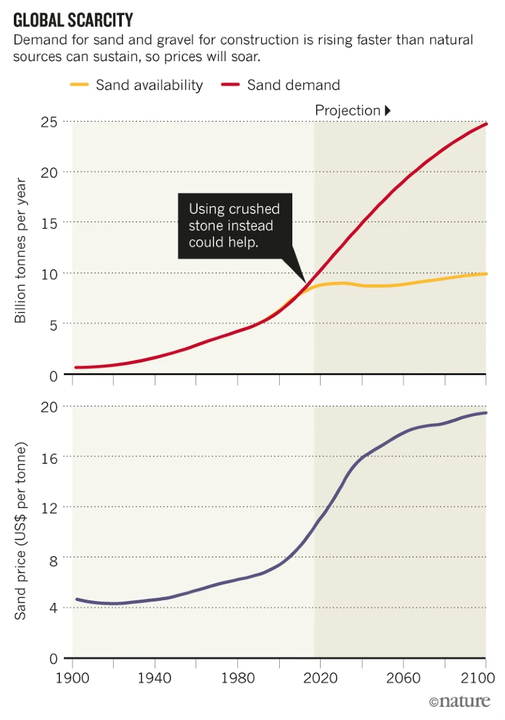

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial as P

# Import manually estimated data to recreate figure due to lack of open data
demand_avail = pd.read_csv("../Data/nature_estimates.csv")

# Fit polynomial regression for demand and availability
demand_coeffs = np.polyfit(demand_avail['year'], demand_avail['demand'], 4)
availability_coeffs = np.polyfit(demand_avail['year'], demand_avail['availability'], 4)

# Extrapolate yearly values using the fitted coefficients
start_year = demand_avail['year'].min()
end_year = 2100

# Generate yearly values
years = np.arange(start_year, end_year + 1)
demand_extrapolated = np.polyval(demand_coeffs, years)
availability_extrapolated = np.polyval(availability_coeffs, years)

# Create a dataframe with extrapolated values
extrapolated = pd.DataFrame({
    'year': years,
    'demand_biltonnes': demand_extrapolated,
    'availability_biltonnes': availability_extrapolated
})

extrapolated.to_csv("../Data/figure_1_sand_demand_avail.csv") # In billion tonnes per year

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original data points
ax.scatter(demand_avail['year'], demand_avail['demand'], color='blue', s=80, zorder=5, label='Demand (data)')
ax.scatter(demand_avail['year'], demand_avail['availability'], color='green', s=80, zorder=5, label='Availability (data)')

ax.scatter(extrapolated['year'], extrapolated['demand_biltonnes'], color='blue', s=80, zorder=5, label='Demand (data)')
ax.scatter(extrapolated['year'], extrapolated['availability_biltonnes'], color='green', s=80, zorder=5, label='Availability (data)')

# Plot extrapolated trend lines
ax.plot(years, demand_extrapolated, color='blue', linestyle='--', linewidth=2, label='Demand (extrapolated)')
ax.plot(years, availability_extrapolated, color='green', linestyle='--', linewidth=2, label='Availability (extrapolated)')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Demand vs Availability - Extrapolated to ' + str(end_year), fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Figure 4

This figure contains data from OEC.world, which can be found [here](https://oec.world/en/visualize/geomap/hs92/export/show/all/52505.52517/2023).
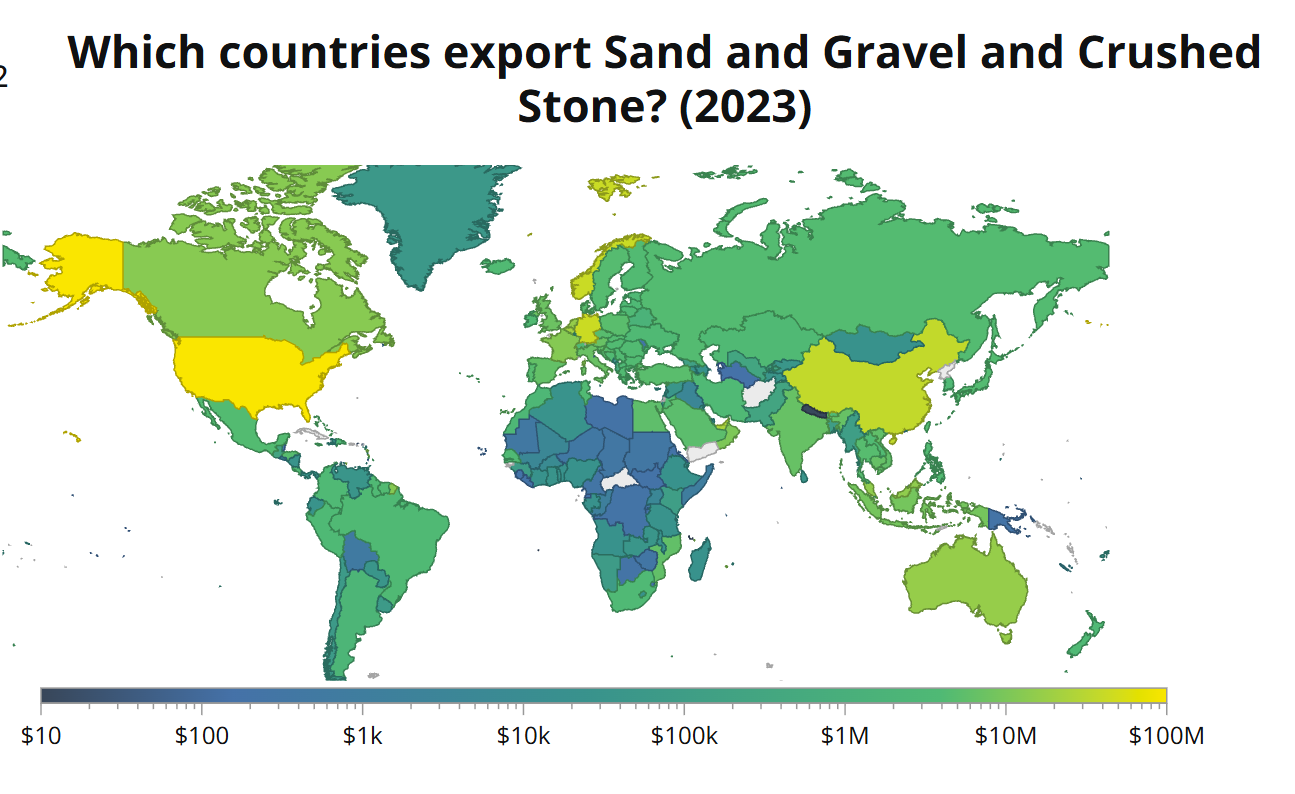

In [ ]:
# Get global timeseries data
import pandas as pd

# Read in data
export_ts = pd.read_csv("../Data/sandgravel_export_timeseries.csv")

# Keep only needed columns
export_ts = export_ts[["Country", "ISO 3", "Trade Value", "Year"]]
export_ts = export_ts.rename(columns={"Trade Value": "Export Value ($)"})

# Sum by year
exports_by_year = export_ts.groupby("Year", as_index=False).agg({"Export Value ($)":"sum"})

# Save
exports_by_year.to_csv("../Data/figure_4_sandgravel_export_timeseries.csv", index=False)

### Figure 4b

In [ ]:
# Top 5 exporting countries
import pandas as pd

# Read in 2023 data
# Includes "Natural sands" and "Gravel and crushed stone"
exports = pd.read_csv("../Data/sandgravel_exports_23.csv")

# Keep only needed columns
exports = exports[["Country", "ISO 3", "Trade Value"]]
exports = exports.rename(columns={"Trade Value": "Export Value ($)"})

# Calculate total
exports_total = exports["Export Value ($)"].sum()
print(f"Total exports ($): {exports_total}")

# Sort and get top 5 countries
exports = exports.sort_values(by = "Export Value ($)", ascending=False)
print(exports.head())

# Save figure
exports.to_csv("../Data/figure_4b_sand_gravel_exporters_2023.csv", index=False)

## Figure 5

This figure contains data from OEC.world, which can be found [here](https://oec.world/en/visualize/geomap/hs92/import/show/all/52505.52517/2023).
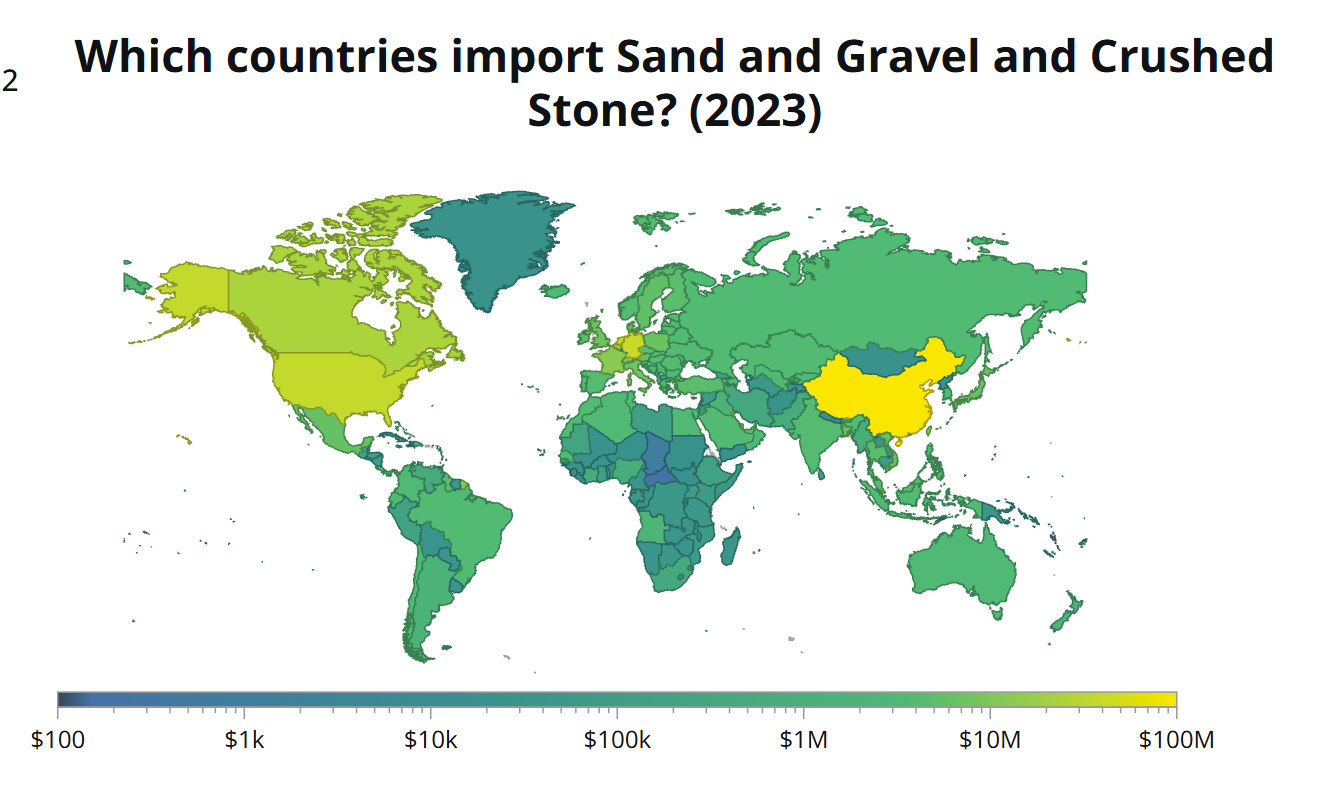

In [ ]:
# Get global timeseries data
import pandas as pd

# Read in data
import_ts = pd.read_csv("../Data/sandgravel_import_timeseries.csv")

# Keep only needed columns
import_ts = import_ts[["Country", "ISO 3", "Trade Value", "Year"]]
import_ts = import_ts.rename(columns={"Trade Value": "Import Value ($)"})

# Sum by year
imports_by_year = import_ts.groupby("Year", as_index=False).agg({"Import Value ($)":"sum"})

# Save
imports_by_year.to_csv("../Data/figure_5_sandgravel_export_timeseries.csv", index=False)

### Figure 5b

In [ ]:
# Top 5 importing countries
import pandas as pd

# Read in 2023 data
# Includes "Natural sands" and "Gravel and crushed stone"
imports = pd.read_csv("../Data/sandgravel_imports_23.csv")

# Keep only needed columns
imports = imports[["Country", "ISO 3", "Trade Value"]]
imports = imports.rename(columns={"Trade Value": "Import Value ($)"})

# Calculate total
imports_total = imports["Import Value ($)"].sum()
print(f"Total imports ($): {imports_total}")

# Sort and get top 5 countries
imports = imports.sort_values(by = "Import Value ($)", ascending=False)
print(imports.head())

# Save figure
imports.to_csv("../Data/figure_5b_sand_gravel_importers_2023.csv", index=False)

# Aquaculture

## Figure 1

This figure contains data from FishStatJ, which can be found [here](https://www.fao.org/fishery/en/statistics/software/fishstatj).

<p align="center">
  <img src="Figs/harvest_aquaculture_1.png" style="width:50%;">
</p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------
# CONFIG
# ------------------------------------------------------
AQUA_FILE = Path("../Data/aquaculture_production.csv")
CAP_FILE  = Path("../Data/capture_production.csv")

OUT_TS_CSV      = Path("../Data/Figure_1a_aquaculture.csv")
OUT_COUNTRY_CSV = Path("../Data/Figure_1b_aquaculture.csv")

START_YEAR = 1950
END_YEAR   = 2022
PLOT = True  # turn on/off plotting

# ------------------------------------------------------
# 1. Load data
# ------------------------------------------------------
aq = pd.read_csv(AQUA_FILE)
cap = pd.read_csv(CAP_FILE)

# Keep only live weight tonnes
aq = aq[aq["Unit (Name)"] == "Tonnes - live weight"].copy()
cap = cap[cap["Unit (Name)"] == "Tonnes - live weight"].copy()

# ------------------------------------------------------
# 2. Extract year columns
# ------------------------------------------------------
def get_year_cols(df):
    cols = [c for c in df.columns if c.startswith("[") and c[1:5].isdigit()]
    years = np.array([int(c.strip("[]")) for c in cols])
    mask = (years >= START_YEAR) & (years <= END_YEAR)
    cols = [c for c, keep in zip(cols, mask) if keep]
    years = years[mask]
    return cols, years

aq_year_cols, years = get_year_cols(aq)
cap_year_cols, years_cap = get_year_cols(cap)
assert np.array_equal(years, years_cap), "Year mismatch between aquaculture and capture files"

# ------------------------------------------------------
# 3. Categorize into marine / inland
# ------------------------------------------------------
# --- Capture fisheries ---
cap = cap.copy()
cap["is_inland"] = cap["FAO major fishing area (Name)"].str.contains("Inland", case=False, na=False)
cap["Category"] = np.where(cap["is_inland"], "Capture_Inland", "Capture_Marine")

# --- Aquaculture production ---
aq = aq.copy()
env = aq["Environment (Name)"].astype(str)

aq["is_inland"] = env.str.contains("Freshwater|Inland", case=False, na=False)
aq["is_marine"] = env.str.contains("Marine|Brackish", case=False, na=False)

aq["Category"] = np.where(aq["is_inland"], "Aqua_Inland", "Aqua_Marine")

# ------------------------------------------------------
# 4. Global totals by year and category
# ------------------------------------------------------
def sum_by_category(df, category_name):
    df2 = df[df["Category"] == category_name]
    vals = df2[year_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
    return vals.sum(axis=0).values

year_cols = aq_year_cols  # same set for both

ts = pd.DataFrame({"Year": years})

ts["Capture_Marine"] = sum_by_category(cap, "Capture_Marine")
ts["Capture_Inland"] = sum_by_category(cap, "Capture_Inland")
ts["Aqua_Marine"]    = sum_by_category(aq, "Aqua_Marine")
ts["Aqua_Inland"]    = sum_by_category(aq, "Aqua_Inland")

# Convert to million tonnes
for col in ["Capture_Marine", "Capture_Inland", "Aqua_Marine", "Aqua_Inland"]:
    ts[col] = ts[col] / 1e6

# Save timeseries
ts.to_csv(OUT_TS_CSV, index=False)
print(f"Saved timeseries to {OUT_TS_CSV}")

# ------------------------------------------------------
# 5. Plot stacked chart (4-category)
# ------------------------------------------------------
if PLOT:
    plt.figure(figsize=(12, 6))
    plt.stackplot(
        ts["Year"],
        ts["Capture_Marine"],
        ts["Capture_Inland"],
        ts["Aqua_Marine"],
        ts["Aqua_Inland"],
        labels=[
            "Capture fisheries – marine areas",
            "Capture fisheries – inland waters",
            "Aquaculture – marine areas",
            "Aquaculture – inland waters"
        ],
        colors=["#bdd7e7", "#6baed6", "#fcbba1", "#cb181d"]
    )
    plt.ylabel("Million tonnes")
    plt.title("Global capture & aquaculture production by environment (1950–2022)")
    plt.legend(loc="upper left", frameon=False)
    plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------
# 6. Country totals for 2022 (aquaculture + capture)
# ------------------------------------------------------
YEAR_COL = "[2022]"

def country_total(df, category_label):
    df = df.copy()
    df["Value"] = pd.to_numeric(df[YEAR_COL], errors="coerce").fillna(0)
    out = df.groupby("Country (Name)", as_index=False)["Value"].sum()
    out = out.rename(columns={"Value": category_label})
    return out

aq_c = country_total(aq,  "Aquaculture_2022_tonnes")
cap_c = country_total(cap, "Capture_2022_tonnes")

country = aq_c.merge(cap_c, on="Country (Name)", how="outer").fillna(0)
country["Total_2022_tonnes"] = country["Aquaculture_2022_tonnes"] + country["Capture_2022_tonnes"]
country["Total_2022_million_tonnes"] = country["Total_2022_tonnes"] / 1e6

country = country.sort_values("Total_2022_tonnes", ascending=False).reset_index(drop=True)

country.to_csv(OUT_COUNTRY_CSV, index=False)
print(f"Saved 2022 country totals to {OUT_COUNTRY_CSV}")

print("\nTop 5 producers in 2022:")
print(country[["Country (Name)", "Total_2022_million_tonnes"]].head(5).to_string(index=False))


## Figure 2

This figure contains data from Food and Agriculture Organization of the United Nations (FAO), via World Bank (2025) – processed by Our World in Data, which can be found [here](https://ourworldindata.org/grapher/aquaculture-farmed-fish-production?tab=map&overlay=download-data).

<p align="center">
  <img src="Figs/harvest_aquaculture_2.png" style="width:50%;">
</p>

## Figure 3

This figure contains data from FishStatJ, which can be found [here](https://www.fao.org/fishery/en/statistics/software/fishstatj).

<p align="center">
  <img src="Figs/harvest_aquaculture_3.png" style="width:50%;">
</p>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
DATA_FILE = Path("../Data/aquaculture_production.csv")
OUTPUT_CSV = Path("../Data/Figure_3_aquaculture.csv")

START_PLOT_YEAR = 2000
END_PLOT_YEAR   = 2022

# Mapping FAO major fishing areas -> regions (tweak if needed)
AREA_TO_REGION = {
    "Africa - Inland waters": "Africa",
    "Atlantic, Eastern Central": "Africa",
    "Atlantic, Southeast": "Africa",
    "Indian Ocean, Western": "Africa",

    "Asia - Inland waters": "Asia",
    "Indian Ocean, Eastern": "Asia",
    "Pacific, Western Central": "Asia",
    "Pacific, Northwest": "Asia",

    "Europe - Inland waters": "Europe",
    "Atlantic, Northeast": "Europe",
    "Mediterranean and Black Sea": "Europe",
    "Former USSR area - Inland waters": "Europe",

    "America, North - Inland waters": "Northern America",
    "Atlantic, Northwest": "Northern America",
    "Pacific, Northeast": "Northern America",

    "America, South - Inland waters": "Latin America and the Caribbean",
    "Atlantic, Western Central": "Latin America and the Caribbean",
    "Atlantic, Southwest": "Latin America and the Caribbean",
    "Pacific, Eastern Central": "Latin America and the Caribbean",
    "Pacific, Southeast": "Latin America and the Caribbean",

    "Oceania - Inland waters": "Oceania",
    "Pacific, Southwest": "Oceania",
}

# ---------------------------------------------------------
# 1. Load and filter species (apply NOTE from figure)
# ---------------------------------------------------------
df = pd.read_csv(DATA_FILE)

pattern = r"\b(crocodile|crocodiles|alligator|alligators|caiman|caimans|" \
          r"corals|pearls|shells|sponges|algae|alga|seaweed|seaweeds|kelp)\b"

exclude_mask = df["ASFIS species (Name)"].astype(str).str.contains(
    pattern, case=False, regex=True, na=False
)

df = df.loc[~exclude_mask].copy()

# ---------------------------------------------------------
# 2. Keep FAO area + year columns
# ---------------------------------------------------------
year_cols = [c for c in df.columns if c.startswith("[") and c[1:5].isdigit()]
years_needed = list(range(1999, END_PLOT_YEAR + 1))
year_cols_needed = [f"[{y}]" for y in years_needed]

df_area = df[["FAO major fishing area (Name)"] + year_cols_needed].copy()
df_area = df_area.rename(columns={"FAO major fishing area (Name)": "Area"})
df_area = df_area.dropna(subset=["Area"])

# ---------------------------------------------------------
# 3. Long format
# ---------------------------------------------------------
long = df_area.melt(
    id_vars="Area",
    value_vars=year_cols_needed,
    var_name="YearStr",
    value_name="Production"
)

long["Year"] = long["YearStr"].str.strip("[]").astype(int)
long.drop(columns="YearStr", inplace=True)

long["Production"] = long["Production"].fillna(0.0)

area_year = (
    long.groupby(["Area", "Year"], as_index=False)["Production"]
        .sum()
)

# ---------------------------------------------------------
# 4. Map FAO area -> region and aggregate
# ---------------------------------------------------------
area_year["Region"] = area_year["Area"].map(AREA_TO_REGION)
area_year = area_year.dropna(subset=["Region"])

region_year = (
    area_year.groupby(["Region", "Year"], as_index=False)["Production"]
        .sum()
)

# ---------------------------------------------------------
# 5. Compute growth rate (%)
# ---------------------------------------------------------
region_year = region_year.sort_values(["Region", "Year"])

region_year["Growth_pct"] = (
    region_year.groupby("Region")["Production"]
    .pct_change() * 100
)

# Restrict to plot years
ts_out = region_year.loc[
    (region_year["Year"] >= START_PLOT_YEAR) &
    (region_year["Year"] <= END_PLOT_YEAR)
].copy()

# ---------------------------------------------------------
# 6. SAVE THE CSV
# ---------------------------------------------------------
ts_out.to_csv(OUTPUT_CSV, index=False)
print(f"Saved timeseries to: {OUTPUT_CSV}")

## Figure 4

This figure contains data from FishStatJ, which can be found [here](https://www.fao.org/fishery/en/statistics/software/fishstatj).

<p align="center">
  <img src="Figs/harvest_aquaculture_4.png" style="width:50%;">
</p>

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pycountry

# ----------------------------------
# Function: Convert FAO country name → ISO3 (no fuzzy)
# ----------------------------------
def country_to_iso3(name):
    if pd.isna(name):
        return None

    # Basic cleanup
    name_clean = str(name).strip()

    # Remove any bracketed/parenthetical suffixes:
    # e.g. "United States of America (USA)" -> "United States of America"
    name_clean = re.sub(r"\s*\(.*?\)\s*$", "", name_clean)

    # Normalize some punctuation
    name_clean = name_clean.replace("&", "and")

    # FAO-specific / variant names
    SPECIAL = {
        "Viet Nam": "VNM",
        "Côte d'Ivoire": "CIV",
        "Dem. People's Rep. of Korea": "PRK",
        "Democratic People's Republic of Korea": "PRK",
        "Republic of Korea": "KOR",
        "Iran (Islamic Republic of)": "IRN",
        "United Republic of Tanzania": "TZA",
        "Russian Federation": "RUS",
        "Bolivia (Plurinational State of)": "BOL",
        "Venezuela (Bolivarian Republic of)": "VEN",
        "Micronesia (Federated States of)": "FSM",
        "Syrian Arab Republic": "SYR",
        "Lao People's Democratic Republic": "LAO",

        # Common FAO / variant names
        "United States": "USA",
        "United States of America": "USA",
        "USA": "USA",
        "U.S.A.": "USA",
        "United Kingdom": "GBR",
        "United Kingdom of Great Britain and Northern Ireland": "GBR",
        "UK": "GBR",
        "China, mainland": "CHN",
        "China, Hong Kong SAR": "HKG",
        "China, Macao SAR": "MAC",
        "China, Taiwan Province of": "TWN",
        "Cabo Verde": "CPV",
        "Czechia": "CZE",
        "Eswatini": "SWZ",
        "State of Palestine": "PSE",
        "Republic of Moldova": "MDA",
        "Timor-Leste": "TLS",
        "North Macedonia": "MKD",
    }

    if name_clean in SPECIAL:
        return SPECIAL[name_clean]

    # 1) Try pycountry lookup
    try:
        return pycountry.countries.lookup(name_clean).alpha_3
    except LookupError:
        pass

    # 2) Case-insensitive exact match
    lower_map = {c.name.lower(): c.alpha_3 for c in pycountry.countries}
    if name_clean.lower() in lower_map:
        return lower_map[name_clean.lower()]

    # Prefer "no ISO" over a wrong ISO
    return None


# ----------------------------------
# CONFIG
# ----------------------------------
FOOD_FILE   = Path("../Data/food_balance.csv")
MAP_FILE    = Path("../Data/country_to_region_from_bt978e.csv")
OUT_CSV     = Path("../Data/Figure_4_aquaculture_timeseries.csv")

START_YEAR  = 1961
END_YEAR    = 2021

REGIONS_ORDER = [
    "Asia",
    "Europe",
    "Africa",
    "Northern America",
    "Latin America and the Caribbean",
    "Oceania",
]

# -----------------------------
# 1. Load food-balance data & filter
# -----------------------------
df = pd.read_csv(FOOD_FILE)

# Use only Total food supply
df = df[df["Element (Name)"] == "Total food supply"].copy()

# Optionally exclude aquatic mammals / reptiles if present in Item (Name)
if "Item (Name)" in df.columns:
    pattern = r"(mammal|mammals|seal|walrus|whale|dolphin|reptile|turtle|crocodil|alligator|caiman)"
    mask_excl = df["Item (Name)"].astype(str).str.contains(
        pattern, case=False, regex=True, na=False
    )
    df = df.loc[~mask_excl].copy()

# -----------------------------
# 2. Melt years into long format
# -----------------------------
year_cols = [c for c in df.columns if c.startswith("[") and c[1:5].isdigit()]

long = df.melt(
    id_vars=["Country (Name)"],
    value_vars=year_cols,
    var_name="YearStr",
    value_name="Quantity"
)

long["Year"] = long["YearStr"].str.strip("[]").astype(int)
long.drop(columns="YearStr", inplace=True)
long = long[(long["Year"] >= START_YEAR) & (long["Year"] <= END_YEAR)]
long["Quantity"] = long["Quantity"].fillna(0.0)

country_year = (
    long.groupby(["Country (Name)", "Year"], as_index=False)["Quantity"]
        .sum()
)

# Add ISO3 for each country
country_year["ISO3"] = country_year["Country (Name)"].apply(country_to_iso3)

# -----------------------------
# 3. Attach Region from bt978e mapping (via ISO3)
# -----------------------------
mapping_raw = pd.read_csv(MAP_FILE)

# New bt978e-derived file should have ISO3 + Region
if "ISO3" in mapping_raw.columns and "Region" in mapping_raw.columns:
    mapping = mapping_raw[["ISO3", "Region"]].dropna().drop_duplicates()
else:
    # Fallback if it's an older Country_Eng/Region style file
    name_col = "Country_Eng" if "Country_Eng" in mapping_raw.columns else "Country (Name)"
    tmp = mapping_raw[[name_col, "Region"]].drop_duplicates()
    tmp["ISO3"] = tmp[name_col].apply(country_to_iso3)
    mapping = tmp[["ISO3", "Region"]].dropna().drop_duplicates()

# Ensure USA present, just in case
if not (mapping["ISO3"] == "USA").any():
    mapping = pd.concat(
        [
            mapping,
            pd.DataFrame([{"ISO3": "USA", "Region": "Northern America"}])
        ],
        ignore_index=True
    )

# Merge on ISO3
country_year = country_year.merge(mapping, on="ISO3", how="left")

# Warn about unmatched countries
missing = country_year[country_year["Region"].isna()][["Country (Name)", "ISO3"]].drop_duplicates()
if not missing.empty:
    print("WARNING: unmatched countries (no region):")
    print(missing.sort_values("Country (Name)").to_string(index=False))

# Drop rows without a Region
country_year = country_year.dropna(subset=["Region"])

# -----------------------------
# 4. Aggregate to region & convert to million tonnes
# -----------------------------
region_year = (
    country_year.groupby(["Region", "Year"], as_index=False)["Quantity"]
        .sum()
)

region_year["Million_tonnes"] = region_year["Quantity"] / 1e6

# (Optionally reorder regions if you care about column order later)
region_year["Region"] = pd.Categorical(region_year["Region"],
                                       categories=REGIONS_ORDER,
                                       ordered=True)
region_year = region_year.sort_values(["Region", "Year"])

# Save tidy timeseries
region_year.to_csv(OUT_CSV, index=False)
print(f"Saved regional timeseries to {OUT_CSV}")


## Figure 5

This figure contains data from FishStatJ, which can be found [here](https://www.fao.org/fishery/en/statistics/software/fishstatj).

<p align="center">
  <img src="Figs/harvest_aquaculture_5.png" style="width:50%;">
</p>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. Load data
# -------------------------------------------------
df = pd.read_csv("../Data/food_balance.csv")

# Year columns look like "[1961]", "[1962]", ... with status cols "S", "S.1", etc.
year_cols = [c for c in df.columns if c.startswith('[') and c[1:5].isdigit()]
years = [int(c.strip("[]")) for c in year_cols]

# -------------------------------------------------
# 2. Aggregate world totals for food & non-food use
# -------------------------------------------------
food_df = df[df["Element (Name)"] == "Total food supply"]
nonfood_df = df[df["Element (Name)"] == "Non-food uses"]

food_totals = food_df[year_cols].sum(axis=0, skipna=True)
nonfood_totals = nonfood_df[year_cols].sum(axis=0, skipna=True)

ts = pd.DataFrame({
    "Year": years,
    "Food_tonnes": food_totals.values,
    "Non_food_tonnes": nonfood_totals.values,
})
ts["Total_use"] = ts["Food_tonnes"] + ts["Non_food_tonnes"]

# Drop early years where everything is zero, just in case
ts = ts[ts["Total_use"] > 0]

# -------------------------------------------------
# 3. Convert to percentage shares
# -------------------------------------------------
ts["Food_share"] = ts["Food_tonnes"] / ts["Total_use"] * 100
ts["Non_food_share"] = ts["Non_food_tonnes"] / ts["Total_use"] * 100

# -------------------------------------------------
# 5. Save the time series as CSV
# -------------------------------------------------
ts_out = ts[["Year", "Food_share", "Non_food_share", "Food_tonnes", "Non_food_tonnes"]]
ts_out.to_csv("../Data/Figure_5_aquaculture.csv", index=False)
print("Saved to ../Data/Figure_5_aquaculture.csv")


## Figure 6

This figure contains data from FishStatJ, which can be found [here](https://www.fao.org/fishery/en/statistics/software/fishstatj).

<p align="center">
  <img src="Figs/harvest_aquaculture_6.png" style="width:50%;">
</p>

In [ ]:
import pandas as pd

# -----------------------------
# 1. Load data
# -----------------------------
aq = pd.read_csv("../Data/aquaculture_production.csv")
asfis = pd.read_csv("../Data/ASFIS_sp_2025.csv")

# Keep only live-weight tonnes
aq = aq[aq["Unit (Name)"] == "Tonnes - live weight"].copy()

# -----------------------------
# 2. Merge aquaculture + ASFIS on English name
# -----------------------------
aq["species_clean"] = aq["ASFIS species (Name)"].str.strip().str.lower()
asfis["species_clean"] = asfis["English_name"].str.strip().str.lower()

merged = aq.merge(asfis, on="species_clean", how="left")

# -----------------------------
# 3. Long format over all years
# -----------------------------
year_cols = [c for c in merged.columns if c.startswith("[") and c.endswith("]")]

long = merged.melt(
    id_vars=["ISSCAAP_Group "],
    value_vars=year_cols,
    var_name="Year",
    value_name="Production_tonnes",
)

# Clean up Year and production
long["Year"] = long["Year"].str.strip("[]").astype(int)
long["Production_tonnes"] = pd.to_numeric(
    long["Production_tonnes"], errors="coerce"
).fillna(0)

# Numeric ISSCAAP group code
long["ISSCAAP_int"] = long["ISSCAAP_Group "].astype("Int64")

# -----------------------------
# 4. Map ISSCAAP group -> Species_group
# -----------------------------
def map_species_group(g):
    # g is a pandas Int64 (can be <NA>)
    if pd.isna(g):
        return "Other aquatic animal species"
    gi = int(g)

    # Finfish: FAO fish groups 11–37 + misc finfish 90–93
    if (11 <= gi <= 37) or (90 <= gi <= 93):
        return "Finfish"
    # Crustaceans
    elif 41 <= gi <= 47:
        return "Crustaceans"
    # Molluscs
    elif 51 <= gi <= 58:
        return "Molluscs"
    # Aquatic plants / algae
    elif 71 <= gi <= 79:
        return "Algae"
    # Everything else: other aquatic animals
    else:
        return "Other aquatic animal species"

long["Species_group"] = long["ISSCAAP_int"].apply(map_species_group)

# -----------------------------
# 5. Global time series by species group
# -----------------------------
ts = (
    long.groupby(["Species_group", "Year"], as_index=False)["Production_tonnes"]
        .sum()
)

# Save out timeseries
out_path = "../Data/Figure_6_aquaculture.csv"
ts.to_csv(out_path, index=False)
print(f"Saved global aquaculture time series by species group to {out_path}")

# -----------------------------
# 6. 2022 percentages (for the sentence)
# -----------------------------
ts_2022 = ts[ts["Year"] == 2022].copy()
total_2022 = ts_2022["Production_tonnes"].sum()
ts_2022["Percent_2022"] = ts_2022["Production_tonnes"] / total_2022 * 100

print("\nGlobal aquaculture production by species group in 2022:")
print(
    ts_2022.sort_values("Percent_2022", ascending=False)[
        ["Species_group", "Production_tonnes", "Percent_2022"]
    ]
)


## Figures 7 and 10

This figure contains data from FishStatJ, which can be found [here](https://www.fao.org/fishery/en/statistics/software/fishstatj).

<p align="center">
  <img src="Figs/harvest_aquaculture_7.png" style="width:50%;">
</p>

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pycountry
from difflib import get_close_matches  # no longer used, but harmless if left


# ----------------------------------
# Function: Convert FAO country name → ISO3 (no fuzzy)
# ----------------------------------
def country_to_iso3(name):
    if pd.isna(name):
        return None

    # Basic cleanup
    name_clean = str(name).strip()

    # Remove any bracketed/parenthetical suffixes:
    # e.g. "United States of America (USA)" -> "United States of America"
    name_clean = re.sub(r"\s*\(.*?\)\s*$", "", name_clean)

    # Normalize some punctuation
    name_clean = name_clean.replace("&", "and")

    # FAO-specific special cases / variant names
    SPECIAL = {
        "Viet Nam": "VNM",
        "Côte d'Ivoire": "CIV",
        "Dem. People's Rep. of Korea": "PRK",
        "Democratic People's Republic of Korea": "PRK",
        "Republic of Korea": "KOR",
        "Iran (Islamic Republic of)": "IRN",
        "United Republic of Tanzania": "TZA",
        "Russian Federation": "RUS",
        "Bolivia (Plurinational State of)": "BOL",
        "Venezuela (Bolivarian Republic of)": "VEN",
        "Micronesia (Federated States of)": "FSM",
        "Syrian Arab Republic": "SYR",
        "Lao People's Democratic Republic": "LAO",

        # Common FAO / variant names
        "United States": "USA",
        "United States of America": "USA",
        "USA": "USA",
        "U.S.A.": "USA",
        "United Kingdom": "GBR",
        "United Kingdom of Great Britain and Northern Ireland": "GBR",
        "UK": "GBR",
        "China, mainland": "CHN",
        "China, Hong Kong SAR": "HKG",
        "China, Macao SAR": "MAC",
        "China, Taiwan Province of": "TWN",
        "Cabo Verde": "CPV",
        "Czechia": "CZE",
        "Eswatini": "SWZ",
        "State of Palestine": "PSE",
        "Republic of Moldova": "MDA",
        "Timor-Leste": "TLS",
        "North Macedonia": "MKD",
    }

    if name_clean in SPECIAL:
        return SPECIAL[name_clean]

    # 1. Try direct lookup (pycountry knows "United States" & "United States of America")
    try:
        return pycountry.countries.lookup(name_clean).alpha_3
    except LookupError:
        pass

    # 2. Try case-insensitive exact match
    lower_map = {c.name.lower(): c.alpha_3 for c in pycountry.countries}
    if name_clean.lower() in lower_map:
        return lower_map[name_clean.lower()]

    # Prefer "no ISO" over a wrong ISO
    return None


# ----------------------------------
# CONFIG
# ----------------------------------
YEAR = 2022                      # change to 2023 etc if you want
YEAR_COL = f"[{YEAR}]"

AQUA_FILE     = "../Data/aquaculture_production.csv"
CAP_FILE      = "../Data/capture_production.csv"
REGION_FILE   = "../Data/country_to_region_from_bt978e.csv"  # built from bt978e.pdf
OUT_FIG7_CSV  = "../Data/Figure_7_aquaculture.csv"
OUT_FIG10_CSV = "../Data/Figure_10_aquaculture.csv"


# ----------------------------------
# 1. Load data
# ----------------------------------
aq = pd.read_csv(AQUA_FILE)
cap = pd.read_csv(CAP_FILE)

# Keep live-weight tonnes only
aq = aq[aq["Unit (Name)"] == "Tonnes - live weight"].copy()
cap = cap[cap["Unit (Name)"] == "Tonnes - live weight"].copy()


# ----------------------------------
# 2. Aggregate global production by species for the chosen year
# ----------------------------------
def aggregate_by_species(df, year_col, value_name):
    df = df.copy()
    df[value_name] = pd.to_numeric(df[year_col], errors="coerce").fillna(0)
    out = (
        df.groupby("ASFIS species (Name)", as_index=False)[value_name]
          .sum()
    )
    return out


aq_species  = aggregate_by_species(aq, YEAR_COL, "Aquaculture_tonnes")
cap_species = aggregate_by_species(cap, YEAR_COL, "Capture_tonnes")


# ----------------------------------
# 3. Merge aquaculture + capture (global)
# ----------------------------------
merged = aq_species.merge(
    cap_species,
    on="ASFIS species (Name)",
    how="outer"
).fillna(0)

# Total production (for ranking)
merged["Total_tonnes"] = merged["Aquaculture_tonnes"] + merged["Capture_tonnes"]

# Convert to million tonnes for plotting (if/when you plot it)
merged["Aquaculture_million"] = merged["Aquaculture_tonnes"] / 1e6
merged["Capture_million"]     = merged["Capture_tonnes"] / 1e6


# ----------------------------------
# 4. Pick top 10 species by total production (Figure 7)
# ----------------------------------
top = (
    merged.sort_values("Total_tonnes", ascending=False)
          .head(10)
          .reset_index(drop=True)
)

top.to_csv(OUT_FIG7_CSV, index=False)
print(f"Saved top-species table to {OUT_FIG7_CSV}")

top_species = top["ASFIS species (Name)"]


# ----------------------------------
# 5. Top species by region & country (with ISO3 added) – Figure 10
# ----------------------------------

# Add ISO3 to aquaculture & capture datasets
aq["ISO3"]  = aq["Country (Name)"].apply(country_to_iso3)
cap["ISO3"] = cap["Country (Name)"].apply(country_to_iso3)

# Load region mapping.
# New bt978e-derived file should have at least: ISO3, Region
region_map_raw = pd.read_csv(REGION_FILE)

if "ISO3" in region_map_raw.columns and "Region" in region_map_raw.columns:
    region_map = region_map_raw[["ISO3", "Region"]].dropna().drop_duplicates()
else:
    # Fallback if old-style file (Country_X + Region) is present:
    name_col = "Country_Eng" if "Country_Eng" in region_map_raw.columns else "Country (Name)"
    tmp = region_map_raw[[name_col, "Region"]].drop_duplicates()
    tmp["ISO3"] = tmp[name_col].apply(country_to_iso3)
    region_map = tmp[["ISO3", "Region"]].dropna().drop_duplicates()

# Ensure USA has a region, just in case
if not (region_map["ISO3"] == "USA").any():
    region_map = pd.concat(
        [
            region_map,
            pd.DataFrame(
                [{"ISO3": "USA", "Region": "Northern America"}]
            )
        ],
        ignore_index=True
    )

# Final clean
region_map = region_map.dropna(subset=["ISO3", "Region"]).drop_duplicates()


def aggregate_by_country_species(df, year_col, value_name):
    df = df.copy()
    df[value_name] = pd.to_numeric(df[year_col], errors="coerce").fillna(0)

    # Merge in region using ISO3
    df = df.merge(region_map[["ISO3", "Region"]], on="ISO3", how="left")

    # Filter to top global species only
    df = df[df["ASFIS species (Name)"].isin(top_species)]

    out = (
        df.groupby(
            ["Region", "Country (Name)", "ISO3", "ASFIS species (Name)"],
            as_index=False
        )[value_name].sum()
    )
    return out


aq_country  = aggregate_by_country_species(aq, YEAR_COL, "Aquaculture_tonnes")
cap_country = aggregate_by_country_species(cap, YEAR_COL, "Capture_tonnes")

# Merge aquaculture and capture at country/species level
country_species = aq_country.merge(
    cap_country,
    on=["Region", "Country (Name)", "ISO3", "ASFIS species (Name)"],
    how="outer"
).fillna(0)

# Total production per country/species
country_species["Total_tonnes"] = (
    country_species["Aquaculture_tonnes"] +
    country_species["Capture_tonnes"]
)

# Keep only rows with non-zero total
country_species = country_species[country_species["Total_tonnes"] > 0].copy()

# ----------------------------------
# Keep only the top species per country (one row per country)
# ----------------------------------
# Sort so that the highest Total_tonnes comes first within each country
country_species = country_species.sort_values(
    ["Region", "Country (Name)", "Total_tonnes"],
    ascending=[True, True, False]
)

# For each (Region, Country, ISO3), keep the first (max Total_tonnes) row
country_top = (
    country_species
    .groupby(["Region", "Country (Name)", "ISO3"], as_index=False)
    .first()
)

# Sort by Region then Total_tonnes descending
country_top = country_top.sort_values(
    ["Region", "Total_tonnes"],
    ascending=[True, False]
).reset_index(drop=True)

country_top.to_csv(OUT_FIG10_CSV, index=False)
print(f"Saved top-species-by-region table to {OUT_FIG10_CSV}")


In [ ]:
region_map.query("Region == 'Northern America'")

## Figures 8 and 11

This figure contains data from Fishery and Aquaculture Statistics – Yearbook 2022. FAO Yearbook of Fishery and Aquaculture Statistics, which can be found [here](https://www.fao.org/fishery/en/statistics/yearbook), specifically Table 10.

<p align="center">
  <img src="Figs/harvest_aquaculture_8.png" style="width:50%;">
</p>

## Figure 9

This figure contains data from Food and Agriculture Organization of the United Nations (2024) – processed by Our World in Data, which can be found [here](https://ourworldindata.org/grapher/fish-and-seafood-consumption-per-capita).

<p align="center">
  <img src="Figs/harvest_aquaculture_9.png" style="width:50%;">
</p>

## Figure 10

This figure contains data from Fishery and Aquaculture Statistics – Yearbook 2022. FAO Yearbook of Fishery and Aquaculture Statistics, which can be found [here](https://www.fao.org/fishery/en/statistics/yearbook), specifically Table 10.

<p align="center">
  <img src="Figs/harvest_aquaculture_10.png" style="width:50%;">
</p>

In [ ]:
# Imports
import pandas as pd
import numpy as np
import json

## Figure 1 (key stats)

Data sourced from FAO FishSTAT via FishStatJ, available [here](https://www.fao.org/fishery/en/topic/166235/en)

Dataset: Global Production by production source 1950-2023 (Release date: March 2025)

In [ ]:
# Import production data
production = pd.read_csv("fao_plants_production.csv", encoding="latin-1")

# Drop all the status columns (columns named 'S' or 'S.1', 'S.2', etc.)
status_cols = [col for col in production.columns if col == 'S' or col.startswith('S.')]
production = production.drop(columns=status_cols)

# Clean up year column names - remove brackets
production.columns = [col.replace('[', '').replace(']', '') for col in production.columns]

production_without_totals = production[~production["Detailed production source (Name)"].isna()]

# Total production in most recent year
total_production = production_without_totals["2023"].sum()
print(f"{total_production/(1e6):.2f} total millions of tonnes produced")

# Percent produced by aquaculture
aquaculture_sources = ['Aquaculture production (freshwater)',
       'Aquaculture production (marine)',
       'Aquaculture production (brackishwater)']
aquaculture_prod = production_without_totals[production_without_totals['Detailed production source (Name)'].isin(aquaculture_sources)]
total_aquaculture_prod = aquaculture_prod["2023"].sum()
perc_aquaculture = np.round(total_aquaculture_prod/total_production*100,decimals=2)
print(f"{perc_aquaculture}% produced by aquaculture")

# Save
key_stats = {"Millions of Tons of Seaweed Produced Annually": total_production/(1e6),
 "Amount of Seaweed Produced by Aquaculture (%)": perc_aquaculture}

with open("fig_1_key_stats.json", "w") as f:
    json.dump(key_stats, f, indent=2)

## Figure 2 + 9

Data sourced from FAO FishSTAT via FishStatJ, available [here](https://www.fao.org/fishery/en/topic/166235/en)

Dataset: Global Production by production source 1950-2023 (Release date: March 2025)

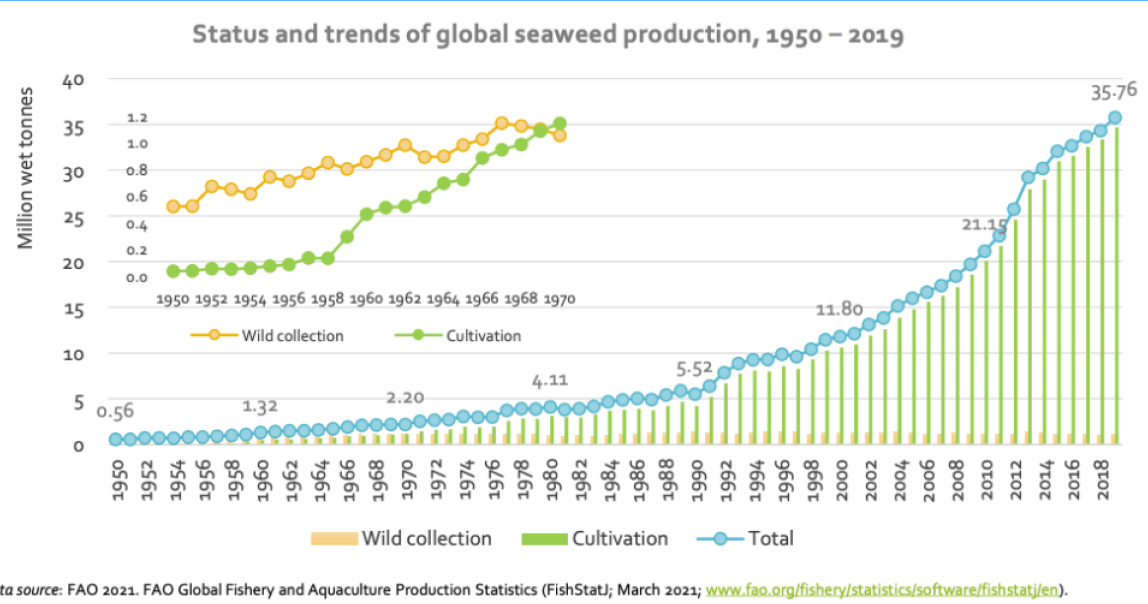

In [ ]:
# Yearly time series, seaweed and algae production (in tonnes)
# Separated into aquaculture, wild, and total

# Get capture production
capture_source = 'Capture production'
capture_prod = production[production['Detailed production source (Name)'] == capture_source]

# Get only the year columns (numeric columns)
year_cols = [col for col in production.columns if col.isdigit()]

# Sum each year column to get total production per year
aquaculture_timeseries = aquaculture_prod[year_cols].sum()
capture_timeseries = capture_prod[year_cols].sum()

# Convert to DataFrame for easier plotting/analysis
aquaculture_timeseries = aquaculture_timeseries.reset_index()
aquaculture_timeseries.columns = ['Year', 'aquaculture_prod_tonnes']
aquaculture_timeseries['Year'] = aquaculture_timeseries['Year'].astype(int)

capture_timeseries = capture_timeseries.reset_index()
capture_timeseries.columns = ['Year', 'capture_prod_tonnes']
capture_timeseries['Year'] = capture_timeseries['Year'].astype(int)

# Get total
total_production_timeseries = production_without_totals[year_cols].sum()
total_production_timeseries = total_production_timeseries.reset_index()
total_production_timeseries.columns = ['Year', 'total_prod_tonnes']
total_production_timeseries['Year'] = total_production_timeseries['Year'].astype(int)

production_timeseries = pd.merge(aquaculture_timeseries, capture_timeseries, how="outer", on="Year")
production_timeseries = pd.merge(production_timeseries, total_production_timeseries, how="outer", on="Year")

# Save timeseries
production_timeseries.to_json("figure_2_9_producers.json", orient="records", indent=4)

# Check mins and maxes
print(production_timeseries["total_prod_tonnes"].min())
print(production_timeseries["total_prod_tonnes"].max())

## Figure 3

From FAO FishSTAT, available [here](https://www.fao.org/fishery/en/topic/166235/en)

Dataset: Global Production by production source 1950-2023 (Release date: March 2025)

Country names from FAO Names of Countries and Territories Dataset, available [here](https://www.fao.org/nocs/en)

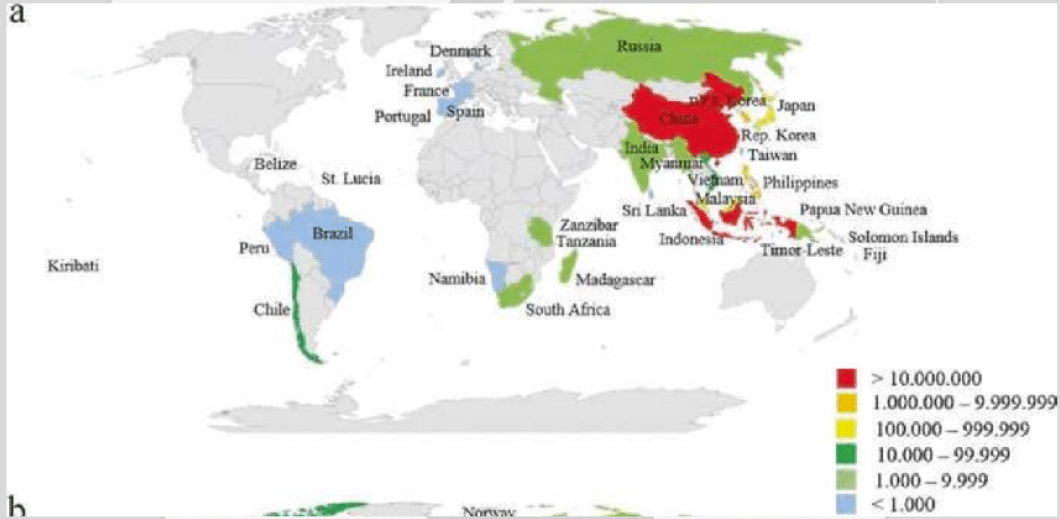

In [ ]:
# Production by country with ISO code for geo mapping (in tonnes)

# Check countries before merging
prod_2023 = production_without_totals[["Country (Name)","2023"]]

# Drop former countries
prod_2023 = prod_2023[~prod_2023["Country (Name)"].isin(["Union of Soviet Socialist Republics [former]", "Sudan [former]"])]
prod_2023_by_country = prod_2023.groupby(by="Country (Name)", as_index=False).agg({"2023":"sum"})

country_codes = pd.read_excel("FAO_country_names.xlsx")[["ISO3", "LIST NAME"]]
prod_2023_iso3 = pd.merge(prod_2023_by_country, country_codes, how="inner",
         left_on="Country (Name)", right_on="LIST NAME").drop(columns="LIST NAME")
prod_2023_iso3 = prod_2023_iso3.rename(columns={"2023": "tonnes_2023"})

# Check for missing countries
matched_countries = list(prod_2023_iso3["Country (Name)"].unique())

all_countries = set(prod_2023_by_country["Country (Name)"].unique())
matched = set(matched_countries)

unmatched = all_countries - matched
print(unmatched)

# Sort values for viewing
prod_by_country = prod_2023_iso3.sort_values(by = "tonnes_2023", ascending=False).reset_index(drop=True)

# Save as json and display top
prod_by_country.to_json("figure_3_biggest_producers.json", orient="records", indent=4)

# Check mins and maxes
print(prod_by_country["tonnes_2023"].min())
print(prod_by_country["tonnes_2023"].max())
prod_by_country.head()

## Figure 6

From the World Bank Global Seaweed New and Emerging Markets Report 2023 - available [here](https://www.worldbank.org/en/topic/environment/publication/global-seaweed-new-and-emerging-markets-report-2023)

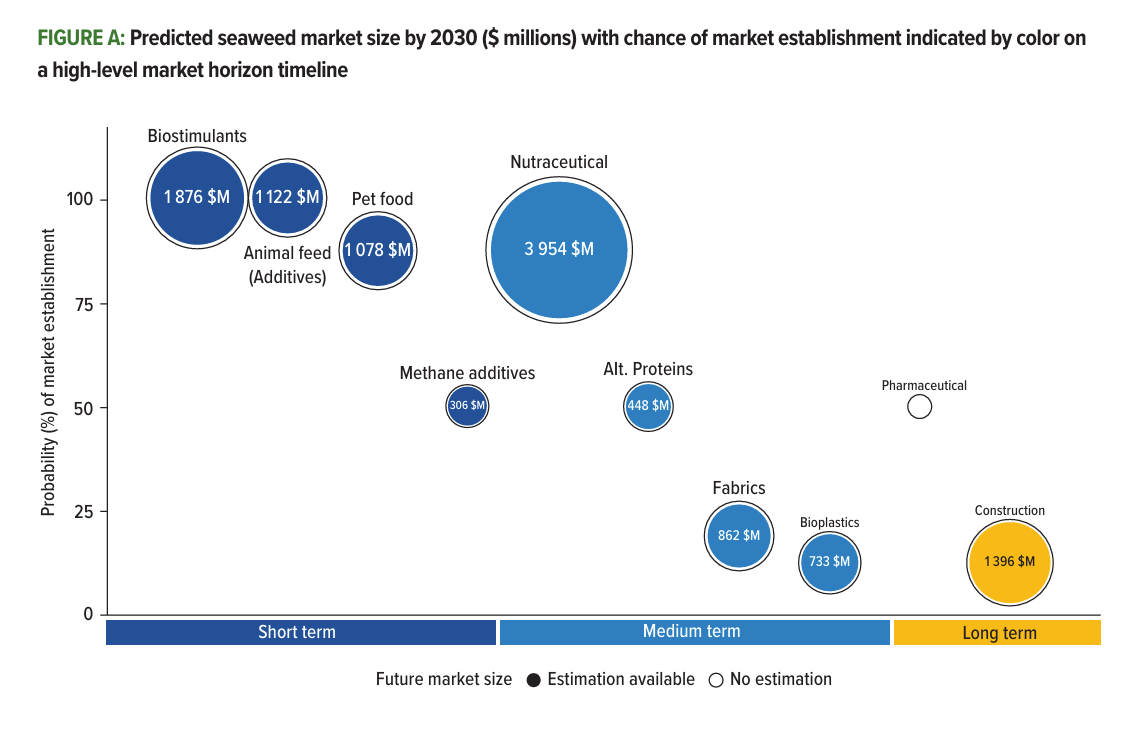

In [ ]:
# Probability, phase, market size from text

markets = {"Market": ["Biostimulants", "Animal feed (Additives)", "Pet food", 
           "Methane additives", "Nutraceutical", "Alt. Proteins", 
           "Fabrics", "Bioplastics", "Pharmaceutical", "Construction"],
            "Market size ($)": [1876000000,1122000000, 1078000000, 
                            306000000, 3954000000, 448000,
                            862000, 733000, None, 1396000000],
            "Probability (%) of market establishment": [100, 100, 87.5,
                                                        50, 87.5, 50,
                                                        18.75, 12.5, 50, 12.5]}

with open("figure_6_seaweed_market.json", "w") as f:
    json.dump(markets, f, indent=2)

## Figure 7 + 8 (trade flow map)

From FAO FishSTAT, available [here](https://www.fao.org/fishery/en/topic/166235/en)

Dataset: Global aquatic trade - By partner country - Quantities and Values - 2019-2023 (Release date: July 2025)

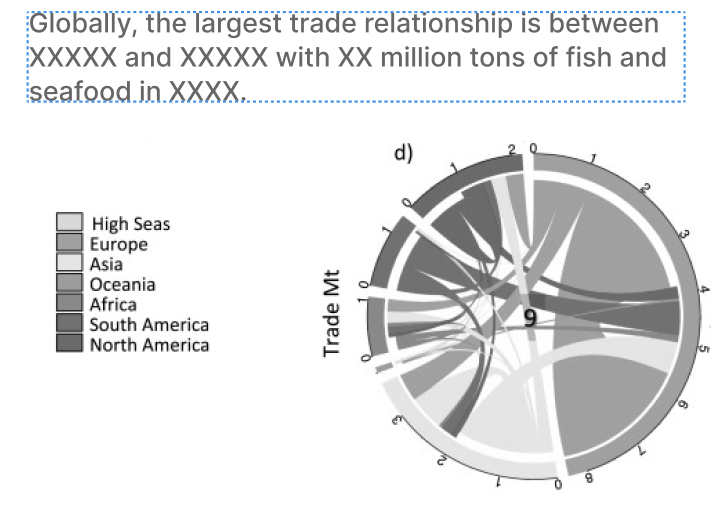

In [ ]:
# Trade relationships (exports in tonnes)

# Import trade data
trade = pd.read_csv("fao_plants_trade.csv", encoding="latin-1")
print(f"Units {trade["Unit (Name)"].unique()}")

# Drop all the status columns (columns named 'S' or 'S.1', 'S.2', etc.)
status_cols = [col for col in trade.columns if col == 'S' or col.startswith('S.')]
trade = trade.drop(columns=status_cols)

# Clean up year column names - remove brackets
trade.columns = [col.replace('[', '').replace(']', '') for col in trade.columns]

trade_2023 = trade.drop(columns = ["2019", "2020", "2021", "2022"])
trade_2023 = trade_2023[~trade_2023["Partner country (Name)"].isna()]
trade_2023 = trade_2023.groupby(["Reporting country (Name)", "Partner country (Name)","Trade flow (Name)"], as_index=False).agg({"2023":"sum"})
trade_2023_exports = trade_2023[trade_2023["Trade flow (Name)"] == "Exports"]
top25 = trade_2023_exports.sort_values("2023", ascending=False)[0:25].reset_index(drop=True)

# Merge with ISO codes
top25_iso3 = pd.merge(top25, country_codes, how="inner",
         left_on="Reporting country (Name)", right_on="LIST NAME").drop(columns="LIST NAME")
top25_iso3 = top25_iso3.rename(columns = {"ISO3": "Reporting ISO3"})

top25_iso3 = pd.merge(top25_iso3, country_codes, how="inner",
         left_on="Partner country (Name)", right_on="LIST NAME").drop(columns="LIST NAME")
top25_iso3 = top25_iso3.rename(columns = {"ISO3": "Partner ISO3"})
top25_iso3 = top25_iso3.rename(columns={"2023": "tonnes_2023"})

top25_iso3.to_json("figure_7_8_top25_export_relationships.json", orient="records", indent=4)
top25_iso3